## Create a Training and Test Data Set:

Logistic Regression:

* Develop a logistic regression model to determine the probability of a loan default. Use all of the variables.
* Develop a logistic regression model to determine the probability of a loan default. Use the variables that were selected by a DECISION TREE.
* Develop a logistic regression model to determine the probability of a loan default. Use the variables that were selected by a RANDOM FOREST.
* Develop a logistic regression model to determine the probability of a loan default. Use the variables that were selected by a GRADIENT BOOSTING model.
* Develop a logistic regression model to determine the probability of a loan default. Use the variables that were selected by STEPWISE SELECTION.
* For each of the models
 - Calculate the accuracy of the model on both the training and test data set
 - Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.
 - Display a ROC curve for the test data with all your models on the same graph (tree based and regression). Discuss which one is the most accurate. Which one would you recommend using?
 - For one of the Regression Models, print the coefficients. Do the variables make sense? If not, what would you recommend?
 
Linear Regression:

* Develop a linear regression model to determine the expected loss if the loan defaults. Use all of the variables.
* Develop a linear regression model to determine the expected loss if the loan defaults. Use the variables that were selected by a DECISION TREE.
* Develop a linear regression model to determine the expected loss if the loan defaults. Use the variables that were selected by a RANDOM FOREST.
* Develop a linear regression model to determine the expected loss if the loan defaults. Use the variables that were selected by a GRADIENT BOOSTING model.
* Develop a linear regression model to determine the expected loss if the loan defaults. Use the variables that were selected by STEPWISE SELECTION.
* For each of the models
 - Calculate the RMSE for both the training data set and the test data set
 - List the RMSE for the test data set for all of the models created (tree based and regression).  
 - Discuss which one is the most accurate. Which one would you recommend using?
 - For one of the Regression Models, print the coefficients. Do the variables make sense? If not, what would you recommend?

In [6]:
# Load Packages
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn import tree
from sklearn.tree import _tree
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
# !pip install memory_profiler
# %load_ext memory_profiler

import warnings
warnings.filterwarnings("ignore")

In [7]:
# Read in dataset and create DataFrame
HMEQ = 'HMEQ_Loss.csv'
df = pd.read_csv(HMEQ)

# Store dtypes in new variable for later use
df_dtypes = df.dtypes

In [8]:
# Inspect DataFrame
df.head(2)

,TARGET_BAD_FLAG,TARGET_LOSS_AMT,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,641.0,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1109.0,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN


In [9]:
# Inspect dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TARGET_BAD_FLAG  5960 non-null   int64  
 1   TARGET_LOSS_AMT  1189 non-null   float64
 2   LOAN             5960 non-null   int64  
 3   MORTDUE          5442 non-null   float64
 4   VALUE            5848 non-null   float64
 5   REASON           5708 non-null   object 
 6   JOB              5681 non-null   object 
 7   YOJ              5445 non-null   float64
 8   DEROG            5252 non-null   float64
 9   DELINQ           5380 non-null   float64
 10  CLAGE            5652 non-null   float64
 11  NINQ             5450 non-null   float64
 12  CLNO             5738 non-null   float64
 13  DEBTINC          4693 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 652.0+ KB


In [10]:
# Exclude target variables for now
# Create new variables names for target variables
TARGET_BF = 'TARGET_BAD_FLAG'
TARGET_LA = 'TARGET_LOSS_AMT'

In [11]:
# Create two lists to store objects by dtypes
objList = []
numList = []

for i in df_dtypes.index:
  if i in ([TARGET_BF, TARGET_LA]): continue
  if df_dtypes[i] in (['object']): objList.append(i)
  if df_dtypes[i] in (['float64', 'int64']): numList.append(i)  

In [12]:
print('List of objects:\n', objList, '\n')
print('List of numeric dtypes:\n', numList, '\n')

List of objects:
 ['REASON', 'JOB'] 

List of numeric dtypes:
 ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'] 



In [13]:
# Inspect all dtypes in objList 
for i in objList:
  show_me = df[i].value_counts(dropna=False)
  print('\n')
  print(show_me)



DebtCon    3928
HomeImp    1780
NaN         252
Name: REASON, dtype: int64


Other      2388
ProfExe    1276
Office      948
Mgr         767
NaN         279
Self        193
Sales       109
Name: JOB, dtype: int64


In [14]:
# Percent of missing values by dtype
df.isna().sum() / len(df)

TARGET_BAD_FLAG    0.000000
TARGET_LOSS_AMT    0.800503
LOAN               0.000000
MORTDUE            0.086913
VALUE              0.018792
REASON             0.042282
JOB                0.046812
YOJ                0.086409
DEROG              0.118792
DELINQ             0.097315
CLAGE              0.051678
NINQ               0.085570
CLNO               0.037248
DEBTINC            0.212584
dtype: float64

In [15]:
# Total missing values by dtypes
df.isna().sum()

TARGET_BAD_FLAG       0
TARGET_LOSS_AMT    4771
LOAN                  0
MORTDUE             518
VALUE               112
REASON              252
JOB                 279
YOJ                 515
DEROG               708
DELINQ              580
CLAGE               308
NINQ                510
CLNO                222
DEBTINC            1267
dtype: int64

In [16]:
# Impute missing values for objects with NaNs in objList
for i in objList:
  df['REASON'] = df['REASON'].fillna(method='ffill')
  df['JOB'] = df['JOB'].fillna(method='ffill')

Notes: 
* Alternative approach to imputing missing values in numList
```
for i in numList :
    theMean = df[i].mean()
    theSD = df[i].std()
    theMax = df[i].max()
    theCutoff = round( theMean + 3*theSD )
    if theMax < theCutoff : continue
    FLAG = "O_" + i
    TRUNC = "TRUNC_" + i
    df[ FLAG ] = ( df[i] > theCutoff )+ 0
    df[ TRUNC ] = df[ i ]
    df.loc[ df[TRUNC] > theCutoff, TRUNC ] = theCutoff
    df = df.drop( i, axis=1 )
```



In [17]:
# Impute missing values for objects with NaNs in numList
for i in numList:
  median_value = df['LOAN'].median()
  df['LOAN'] = df['LOAN'].fillna(value=median_value)

  median_value = df['MORTDUE'].median()
  df['MORTDUE'] = df['MORTDUE'].fillna(value=median_value)

  median_value = df['VALUE'].median()
  df['VALUE'] = df['VALUE'].fillna(value=median_value)

  mean_value = df['YOJ'].mean()
  df['YOJ'] = df['YOJ'].fillna(value=mean_value)

  mean_value = df['DEROG'].mean()
  df['DEROG'] = df['DEROG'].fillna(value=mean_value)

  mean_value = df['DELINQ'].mean()
  df['DELINQ'] = df['DELINQ'].fillna(value=mean_value)
  
  mean_value = df['CLAGE'].mean()
  df['CLAGE'] = df['CLAGE'].fillna(value=mean_value)

  mean_value = df['NINQ'].mean()
  df['NINQ'] = df['NINQ'].fillna(value=mean_value)

  mean_value = df['CLNO'].mean()
  df['CLNO'] = df['CLNO'].fillna(value=mean_value)

  mean_value = df['DEBTINC'].mean()
  df['DEBTINC'] = df['DEBTINC'].fillna(value=mean_value)

In [18]:
# Impute missing values for target variables 
median_value = df['TARGET_LOSS_AMT'].median()
df['TARGET_LOSS_AMT'] = df['TARGET_LOSS_AMT'].fillna(value=median_value)

In [19]:
# Verify all missing values have been imputed
df.isna().sum()

TARGET_BAD_FLAG    0
TARGET_LOSS_AMT    0
LOAN               0
MORTDUE            0
VALUE              0
REASON             0
JOB                0
YOJ                0
DEROG              0
DELINQ             0
CLAGE              0
NINQ               0
CLNO               0
DEBTINC            0
dtype: int64

Notes:
* To prevent a ValueError later when applying regression to all variables


In [20]:
# Perform one-hot-encoding on objList to convert object variables to numeric
# Loop through each object list (objList and numList)
for i in objList :
  print("Class = ", i )
  thePrefix = "IMP_" + i
  print( thePrefix )
  y = pd.get_dummies(df[i], prefix = thePrefix, dummy_na = False)
  print(type(y) )
  print(y.head().T )
  df = pd.concat([df, y], axis = 1 )
  df = df.drop(i, axis = 1 )

print(df.head().T)

Class =  REASON
IMP_REASON
<class 'pandas.core.frame.DataFrame'>
                    0  1  2  3  4
IMP_REASON_DebtCon  0  0  0  0  0
IMP_REASON_HomeImp  1  1  1  1  1
Class =  JOB
IMP_JOB
<class 'pandas.core.frame.DataFrame'>
                 0  1  2  3  4
IMP_JOB_Mgr      0  0  0  0  0
IMP_JOB_Office   0  0  0  0  1
IMP_JOB_Other    1  1  1  1  0
IMP_JOB_ProfExe  0  0  0  0  0
IMP_JOB_Sales    0  0  0  0  0
IMP_JOB_Self     0  0  0  0  0
                               0             1  ...             3              4
TARGET_BAD_FLAG         1.000000      1.000000  ...      1.000000       0.000000
TARGET_LOSS_AMT       641.000000   1109.000000  ...   1425.000000   11003.000000
LOAN                 1100.000000   1300.000000  ...   1500.000000    1700.000000
MORTDUE             25860.000000  70053.000000  ...  65019.000000   97800.000000
VALUE               39025.000000  68400.000000  ...  89235.500000  112000.000000
YOJ                    10.500000      7.000000  ...      8.922268      

### Split Data into **Training** and **Test** Data Set
---
* Main DataFrame: `df`
* dtypes DataFrame: `dtypes_df`
* all inputs variables DataFrame: `X_df`

* X_train
* X_test
* Y_train
* Y_test

In [21]:
X_df = df.copy()
X_df = X_df.drop(TARGET_BF, axis=1)
X_df = X_df.drop(TARGET_LA, axis=1)
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LOAN                5960 non-null   int64  
 1   MORTDUE             5960 non-null   float64
 2   VALUE               5960 non-null   float64
 3   YOJ                 5960 non-null   float64
 4   DEROG               5960 non-null   float64
 5   DELINQ              5960 non-null   float64
 6   CLAGE               5960 non-null   float64
 7   NINQ                5960 non-null   float64
 8   CLNO                5960 non-null   float64
 9   DEBTINC             5960 non-null   float64
 10  IMP_REASON_DebtCon  5960 non-null   uint8  
 11  IMP_REASON_HomeImp  5960 non-null   uint8  
 12  IMP_JOB_Mgr         5960 non-null   uint8  
 13  IMP_JOB_Office      5960 non-null   uint8  
 14  IMP_JOB_Other       5960 non-null   uint8  
 15  IMP_JOB_ProfExe     5960 non-null   uint8  
 16  IMP_JO

In [22]:
# Create another DataFrame for target varibles
Y_df = df[[TARGET_BF, TARGET_LA]]
Y_df.head().T

,0,1,2,3,4
TARGET_BAD_FLAG,1.0,1.0,1.0,1.0,0.0
TARGET_LOSS_AMT,641.0,1109.0,767.0,1425.0,11003.0


Notes:
* Main DataFrame: df
* All input variables DataFrame: X_df
* Target Variables DataFrame: Y_df
* dtypes: df_dtypes
* We want to predict the likelihood of loan default
* TARGET_LA = 'TARGET_LOSS_AMT' = loan default
* numList = numeric variables excluding target variables

In [23]:
# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X_df, Y_df, train_size=0.8,
                                                    test_size=0.2, random_state=4)
print('FLAG DATA:')
print('TRAINING DATA = ', X_train.shape)
print('TEST DATA = ', X_test.shape, '\n')

FLAG DATA:
TRAINING DATA =  (4768, 18)
TEST DATA =  (1192, 18) 



## Quick Analysis (Finding Most Important Features - Non-REG)
---
Notes:
* No Logistic or Linear Regression performed yet


### Simple Decision Tree

In [24]:
# Create a decision tree classifier with respect to TARGET_BF
fm01_Tree = tree.DecisionTreeClassifier(random_state=4, max_depth=5)
fm01_Tree = fm01_Tree.fit(X_train, Y_train[TARGET_BF])

In [25]:
# Score predictions for Y_train and Y_test
Y_pred_train = fm01_Tree.predict(X_train)
Y_pred_test = fm01_Tree.predict(X_test)

In [26]:
# Display accuracy of prediction
print('Train Accuracy:', metrics.accuracy_score(Y_train[TARGET_BF], Y_pred_train))
print('Test Accuracy (new data):', metrics.accuracy_score(Y_test[TARGET_BF], Y_pred_test))

Train Accuracy: 0.8913590604026845
Test Accuracy (new data): 0.886744966442953


Notes:
* `Y_train[TARGET_BF]` is what actually happened 
* `probs_grp1` is the associated probability value for what happened
 - Column 0 contains row data for Current
 - Column 1 contains row data for Loan Default
threshold: acts like a trigger to initiate some action you want to perform

In [27]:
# Create a prediction using probability value 
print('Probability of Loan Default')
probs = fm01_Tree.predict_proba(X_train)
probs_grp1 = probs[0:10] # Lists first 10 people and their associated probability 
probs_grp1

Probability of Loan Default


array([[0.98286938, 0.01713062],
       [0.98286938, 0.01713062],
       [0.39772727, 0.60227273],
       [0.93568465, 0.06431535],
       [0.98286938, 0.01713062],
       [0.98286938, 0.01713062],
       [0.85576923, 0.14423077],
       [0.9371293 , 0.0628707 ],
       [0.21276596, 0.78723404],
       [0.9371293 , 0.0628707 ]])

* Using train data below

In [28]:
# Predict probability of outcomes
probs = fm01_Tree.predict_proba(X_train)
probs_grp2 = probs[:,1] # Look across all rows in Column 1 
false_pos_rate_train, true_pos_rate_train, threshold = metrics.roc_curve(Y_train[TARGET_BF], probs_grp2)
# print(probs_grp2[0:10],'\n') # Grabs first 10 probabilites 

# Represents area under the ROC Curve (training data)
roc_auc_train = metrics.auc(false_pos_rate_train, true_pos_rate_train)

* Using test data below

In [29]:
# Predict probability of outcomes
probs = fm01_Tree.predict_proba(X_test)
probs_grp2 = probs[:,1] # Look across all rows in Column 1 
false_pos_rate_test, true_pos_rate_test, threshold = metrics.roc_curve(Y_test[TARGET_BF], probs_grp2)

# Represents area under the ROC Curve (test data)
roc_auc_test = metrics.auc(false_pos_rate_test, true_pos_rate_test)

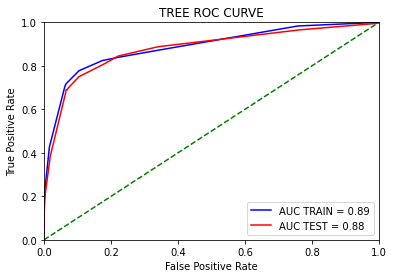

In [30]:
# Create ROC Curve
plt.title('TREE ROC CURVE')
plt.plot(false_pos_rate_train, true_pos_rate_train, 'b',
         label='AUC TRAIN = %0.2f' % roc_auc_train, color='blue')
plt.plot(false_pos_rate_test, true_pos_rate_test, 'b',
         label='AUC TEST = %0.2f' % roc_auc_test, color='red')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### RMSE of Decision Tree

In [31]:
# Create a decision tree regressor with respect to TARGET_A
amt_m01_Tree = tree.DecisionTreeRegressor(random_state=4, max_depth=5)
amt_m01_Tree = amt_m01_Tree.fit(X_train, Y_train[TARGET_LA])

In [32]:
# Score predictions for Y_pred_train and Y_pred_test
Y_pred_train = fm01_Tree.predict(X_train)
Y_pred_test = fm01_Tree.predict(X_test)

Notes:
* MAE shows a ~94 pt difference between train and test data
* RMSE shows a ~144 pt difference between train and test data
 - Not a significant difference for each measure of error to raise concerns

In [33]:
# Inspect mean value for train and test
print("MEAN Train", Y_train[TARGET_LA].mean())
print("MEAN Test", Y_test[TARGET_LA].mean())

MEAN Train 11465.165058724831
MEAN Test 11559.847315436242


In [34]:
# Tree search
def getTreeVars(TREE, varNames):
  tree_ = TREE.tree_
  varName = [varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature]

  nameSet = set()
  for i in tree_.feature :
      if i != _tree.TREE_UNDEFINED :
          nameSet.add(i)
  nameList = list(nameSet)
  parameter_list = list()
  for i in nameList :
      parameter_list.append(varNames[i])
  return parameter_list

In [35]:
# Perform RMSE
RMSE_TRAIN = math.sqrt(metrics.mean_squared_error(Y_train[TARGET_LA], Y_pred_train))
RMSE_TEST = math.sqrt(metrics.mean_squared_error(Y_test[TARGET_LA], Y_pred_test))
print("TREE RMSE Train:", RMSE_TRAIN)
print("TREE RMSE Test:", RMSE_TEST, '\n')

RMSE_TREE = RMSE_TEST
feature_cols = list(X_df.columns.values)
vars_tree_amt = getTreeVars(fm01_Tree, feature_cols)

TREE RMSE Train: 12470.169015265803
TREE RMSE Test: 12614.25583979406 



### Finding the most important features (ordered by precendence)
1.   DEBTINC
2.   DELINQ
3.   CLAGE
4.   DEROG

Other variables used significantly less than the Top 4 variables above were `MORTDUE`, `VALUE`, `YOJ` to include categorical variables `REASON` and `JOB`

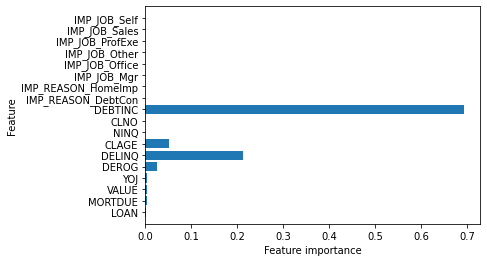

In [37]:
def feature_importance(model):
  n_features = X_train.shape[1]
  plt.barh(np.arange(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), X_train.columns)
  plt.xlabel("Feature importance")
  plt.ylabel("Feature")
  plt.ylim(-1, n_features)
feature_importance(fm01_Tree)

### Random Forest 
* No Logistic or Linear Regression performed yet

In [38]:
# Create tree search function for Random Forests (from lecture notes)
def getEnsembleTreeVars(ENSTREE, varNames) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average(ENSTREE.feature_importances_):
            v = int(imp_val / np.max(ENSTREE.feature_importances_) * 100)
            theList.append((varNames[i], v ))
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

In [39]:
# Create a RandomForestClassifier 
# Fit model to data (models are dynamic, data is static)
fm01_RF = RandomForestClassifier(random_state=4, max_depth=5)
fm01_RF = fm01_RF.fit(X_train, Y_train[TARGET_BF])

In [40]:
# Predict probability of outcomes
probs = fm01_RF.predict_proba(X_test)
p1 = probs[:, 1]
fpr_test, tpr_test, threshold = metrics.roc_curve(Y_test[TARGET_BF], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

In [44]:
# Store variables values in new variables
fpr_RF = fpr_test
tpr_RF = tpr_test
auc_RF = roc_auc_test

In [45]:
# Predict probability of outcomes
probs = fm01_RF.predict_proba(X_train)
p1 = probs[:, 1]
fpr_train, tpr_train, threshold = metrics.roc_curve(Y_train[TARGET_BF], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

In [46]:
# Gather relevant variables used in model prediction
feature_cols = list(X_df.columns.values)
vars_RF_flag = getEnsembleTreeVars(fm01_RF, feature_cols)

# Output best predictor variable/s
for i in vars_RF_flag :
   print(i)

('DEBTINC', 100)
('DELINQ', 65)
('DEROG', 43)
('CLAGE', 22)
('LOAN', 19)


In [47]:
# Score predictions for Y_Pred_train and Y_Pred_test
Y_Pred_train = fm01_RF.predict(X_train)
Y_Pred_test = fm01_RF.predict(X_test)

In [48]:
print("RANDOM FOREST\n")
print("Probability of Loan Default")
print("Train Accuracy:",metrics.accuracy_score(Y_train[TARGET_BF], Y_Pred_train))
print("Test Accuracy:",metrics.accuracy_score(Y_test[TARGET_BF], Y_Pred_test))

RANDOM FOREST

Probability of Loan Default
Train Accuracy: 0.865981543624161
Test Accuracy: 0.8540268456375839


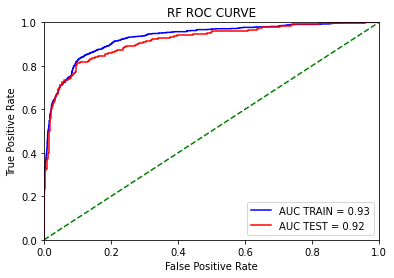

In [49]:
# Create ROC Curve
plt.title('RF ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### RMSE of Random Forest


In [50]:
# Create a RandomForestRegressor with respect to TARGET_A
# Fit model to data (models are dynamic, data is static)
amt_m01_RF = RandomForestRegressor(random_state=4, max_depth=5)
amt_m01_RF = amt_m01_RF.fit(X_train, Y_train[TARGET_LA])

In [51]:
# Score predictions for X_train and X_test
Y_Pred_train = amt_m01_Tree.predict(X_train)
Y_Pred_test = amt_m01_Tree.predict(X_test)

In [52]:
# Inspect mean value for train and test
RMSE_TRAIN = math.sqrt(metrics.mean_squared_error(Y_train[TARGET_LA],
                                                   Y_Pred_train))
RMSE_TEST = math.sqrt(metrics.mean_squared_error(Y_test[TARGET_LA],
                                                  Y_Pred_test))

print("RF RMSE Train", RMSE_TRAIN)
print("RF RMSE Test", RMSE_TEST)

RF RMSE Train 3383.2182835131935
RF RMSE Test 3315.6798722485623


In [53]:
# List the variables included in the Random Forest that predict loss amount
RMSE_RF = RMSE_TEST
feature_cols = list(X_df.columns.values)
vars_RF_amt = getEnsembleTreeVars(amt_m01_RF, feature_cols)

# Output best predictor variable/s
for i in vars_RF_amt :
   print(i)

('LOAN', 100)
('DELINQ', 74)
('CLNO', 26)
('DEBTINC', 25)


### Finding the most important features (ordered by precendence)
1.   `DEBTINC`
2.   `DELINQ`
3.   `DEROG`
4.   `CLAGE`
5.   `LOAN`
6.   `NINQ`
7.   `CLINO` and `VALUE`
8.   `MORTDUE`
9.   `YOJ`

Other variables used significantly less than the Top 9 variables above were categorical variables `REASON` and `JOB`

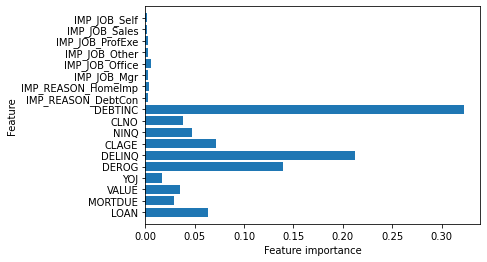

In [54]:
def feature_importance(model):
  n_features = X_train.shape[1]
  plt.barh(np.arange(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), X_train.columns)
  plt.xlabel("Feature importance")
  plt.ylabel("Feature")
  plt.ylim(-1, n_features)
feature_importance(fm01_RF)

### Gradient Boosting
* No Logistic or Linear Regression performed yet

In [55]:
# Create a GradientBoostingClassifier with respect to TARGET_F
fm01_GB = GradientBoostingClassifier(random_state=4, max_depth=5)
fm01_GB = fm01_GB.fit(X_train, Y_train[TARGET_BF])

In [58]:
# Score predictions for X_train and X_test
Y_Pred_train = fm01_GB.predict(X_train)
Y_Pred_test = fm01_GB.predict(X_test)

In [59]:
# Display accuracy of prediction
print("GRADIENT BOOSTING\n")
print("Probability of Loan Default")
print("Train Accuracy:",metrics.accuracy_score(Y_train[TARGET_BF], Y_Pred_train))
print("Test Accuracy:",metrics.accuracy_score(Y_test[TARGET_BF], Y_Pred_test))

GRADIENT BOOSTING

Probability of Loan Default
Train Accuracy: 0.9658137583892618
Test Accuracy: 0.9177852348993288


In [60]:
# Store variables values in new variables
fpr_GB = fpr_test
tpr_GB = tpr_test
auc_GB = roc_auc_test

In [61]:
# Predict probability of outcomes
probs = fm01_GB.predict_proba(X_train)
p1 = probs[:,1]
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_BF], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

In [62]:
# Predict probability of outcomes
probs = fm01_GB.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_BF], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

Notes: 
* *Gradient Boosting* model has the highest test data accuracy of 95% 

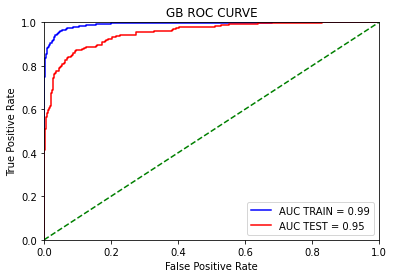

In [63]:
plt.title('GB ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [64]:
# List the variables included in the Gradient Boosting that predict loss amount
feature_cols = list(X_df.columns.values)
vars_GB_flag = getEnsembleTreeVars(fm01_GB, feature_cols)

# Output best predictor variable/s
for i in vars_GB_flag :
   print(i)

('DEBTINC', 100)
('DELINQ', 33)
('CLAGE', 19)
('MORTDUE', 13)


#### RMSE of Gradient Boosting

In [65]:
# Create a GradientBoostingRegressor with respect to TARGET_A
# Fit model to data (models are dynamic, data is static)
amt_m01_GB = GradientBoostingRegressor(random_state=4, max_depth=5)
amt_m01_GB = amt_m01_GB.fit( X_train, Y_train[TARGET_LA])

In [66]:
# Score predictions for X_train and X_test
Y_Pred_train = amt_m01_GB.predict(X_train)
Y_Pred_test = amt_m01_GB.predict(X_test)

In [67]:
# Inspect mean value for train and test
RMSE_TRAIN = math.sqrt(metrics.mean_squared_error(Y_train[TARGET_LA], Y_Pred_train))
RMSE_TEST = math.sqrt(metrics.mean_squared_error(Y_test[TARGET_LA], Y_Pred_test))

print("GB RMSE Train:", RMSE_TRAIN)
print("GB RMSE Test:", RMSE_TEST)

GB RMSE Train: 1500.9969536224444
GB RMSE Test: 2350.023037847418


In [68]:
# List the variables included in the Gradient Boosting that predict loss amount
RMSE_GB = RMSE_TEST
feature_cols = list(X_df.columns.values)
vars_GB_amt = getEnsembleTreeVars(amt_m01_GB, feature_cols)

# Output best predictor variable/s
for i in vars_GB_amt :
   print(i)

('LOAN', 100)
('DEBTINC', 64)
('DELINQ', 63)
('CLNO', 30)
('MORTDUE', 28)
('CLAGE', 22)


### Finding the most important features (ordered by precendence)
1.   `DEBTINC`
2.   `DELINQ`
3.   `CLAGE`
4.   `MORTDUE`
5.   `VALUE` 
6.   `CLINO` and `LOAN`
7.   `YOJ`
8.   `NINQ`

Other variables used significantly less than the Top 8 variables above were categorical variables `REASON` and `JOB`

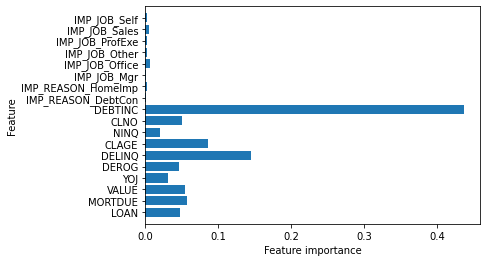

In [69]:
def feature_importance(model):
  n_features = X_train.shape[1]
  plt.barh(np.arange(n_features), model.feature_importances_, align='center')
  plt.yticks(np.arange(n_features), X_train.columns)
  plt.xlabel("Feature importance")
  plt.ylabel("Feature")
  plt.ylim(-1, n_features)
feature_importance(fm01_GB)

## Quick Experiment (Cross-Validation, k=10)
- Cross-Validation using K=10 on Linear Regression

---

### Cross-validation with k=10 using Linear Regression
Notes:
* Too few iterations result in less accuracy for test data (e.g. max_iter=100). When increasing iterations for training (e.g., max_iter=1000+) accuracy sometimes increases for test data. 
  - To detect overfitting, I did not see high train % accuracy and a low test % accuracy.

#### Addressing uncertainty in ML modeling
* I want to prevent overfitting by using cross-validation on our train data without touching our test data. This allows me to fit and evaluate models with various hyperparameters using only train data. 
 - Upon seeing the results from train data, I applied cross validation on test data and saw similar results


In [70]:
# Load packages
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute
from numpy import sqrt

In [71]:
# Perform cross-validation
# Define cross-validation method to use
cv = KFold(n_splits=10, random_state=4, shuffle=True)

# Build multiple linear regression model
model = LinearRegression()

# Use k-fold CV to evaluate model
scores = cross_val_score(model, X_train, Y_train, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)
                      
# View mean absolute error
print('MAE:', mean(absolute(scores)))

# View RMSE
print('RMSE:', sqrt(mean(absolute(scores))))

MAE: 1224.7614973407574
RMSE: 34.99659265329637


In [72]:
# Perform cross-validation
# Define cross-validation method to use
cv = KFold(n_splits=10, random_state=4, shuffle=True)

# Build multiple linear regression model
model = LinearRegression()

# Use k-fold CV to evaluate model
scores = cross_val_score(model, X_test, Y_test, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)
                      
# View mean absolute error
print('MAE:', mean(absolute(scores)))

# View RMSE
print('RMSE:', sqrt(mean(absolute(scores))))

MAE: 1286.381357813389
RMSE: 35.866158949814924


# Regression




Notes:
* Before applying regression to all variables, convert strings to numeric values. My assumption here is that we need to perform one-hot-encoding on objList and pull back into the main dataframe `df`

Notes:
* Custom functions to compute model accuracy (from Lecture notes)
```
def getProbAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    probs = MODEL.predict_proba( X )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]
```
```
def print_ROC_Curve( TITLE, LIST ) :
    fig = plt.figure(figsize=(6,4))
    plt.title( TITLE )
    for theResults in LIST :
        NAME = theResults[0]
        fpr = theResults[2]
        tpr = theResults[3]
        auc = theResults[4]
        theLabel = "AUC " + NAME + ' %0.2f' % auc
        plt.plot(fpr, tpr, label = theLabel )
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
```
```
def print_Accuracy( TITLE, LIST ) :
    print( TITLE )
    print( "======" )
    for theResults in LIST :
        NAME = theResults[0]
        ACC = theResults[1]
        print( NAME, " = ", ACC )
    print( "------\n\n" )
```
```
def getAmtAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    MEAN = Y.mean()
    RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
    return [NAME, RMSE, MEAN]
```
```
def getTreeVars( TREE, varNames ) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add( i )
    nameList = list( nameSet )
    parameter_list = list()
    for i in nameList :
        parameter_list.append( varNames[i] )
    return parameter_list
```
```
def getCoefLogit( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_[0]
    for coef, feat in zip(MODEL.coef_[0],varNames):
        coef_dict[feat] = coef
    print("\nCRASH")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )
```
```
def getCoefLinear( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_
    for coef, feat in zip(MODEL.coef_,varNames):
        coef_dict[feat] = coef
    print("\nDAMAGES")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )
```

#### Model Accuracy Metrics

In [103]:
# Custom functions from lecture notes
def getProbAccuracyScores( NAME, MODEL, X, Y ) :
  pred = MODEL.predict( X )
  probs = MODEL.predict_proba( X )
  acc_score = metrics.accuracy_score(Y, pred)
  p1 = probs[:,1]
  fpr, tpr, threshold = metrics.roc_curve( Y, p1)
  auc = metrics.auc(fpr,tpr)
  return [NAME, acc_score, fpr, tpr, auc]

def getAmtAccuracyScores( NAME, MODEL, X, Y ) :
  pred = MODEL.predict( X )
  MEAN = Y.mean()
  RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
  return [NAME, RMSE, MEAN]

def print_ROC_Curve( TITLE, LIST ) :
  fig = plt.figure(figsize=(6,4))
  plt.title( TITLE )
  for theResults in LIST :
      NAME = theResults[0]
      fpr = theResults[2]
      tpr = theResults[3]
      auc = theResults[4]
      theLabel = "AUC " + NAME + ' %0.2f' % auc
      plt.plot(fpr, tpr, label = theLabel )
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

def print_Accuracy( TITLE, LIST ) :
  print( TITLE )
  print( "======" )
  for theResults in LIST :
      NAME = theResults[0]
      ACC = theResults[1]
      print( NAME, " = ", ACC )
  print( "------\n\n" )

def getCoefLogit( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_[0]
    for coef, feat in zip(MODEL.coef_[0],varNames):
        coef_dict[feat] = coef
    print("\nLOAN DEFAULT")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )

def getCoefLinear( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_
    for coef, feat in zip(MODEL.coef_,varNames):
        coef_dict[feat] = coef
    print("\nLOSS AMOUNT")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )

### Decision Tree (non-REG)

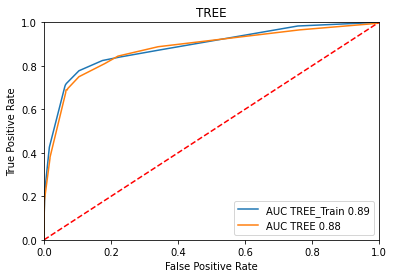

TREE CLASSIFICATION ACCURACY
TREE_Train  =  0.8913590604026845
TREE  =  0.886744966442953
------


TREE RMSE ACCURACY
TREE_Train  =  3682.444532123422
TREE  =  3522.0650799548084
------




In [83]:
# Loan Default
WHO = "TREE"

CLM = tree.DecisionTreeClassifier(random_state=4, max_depth=5)
CLM = CLM.fit(X_train, Y_train[TARGET_BF])

TRAIN_CLM = getProbAccuracyScores(WHO + "_Train", CLM, X_train, Y_train[TARGET_BF])
TEST_CLM = getProbAccuracyScores(WHO, CLM, X_test, Y_test[TARGET_BF])

print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

feature_cols = list(X_df.columns.values)
tree.export_graphviz(CLM, out_file='tree_f.txt',filled=True,
                     rounded=True, feature_names = feature_cols,
                     impurity=False, class_names=["Good","Bad"])
vars_tree_flag = getTreeVars(CLM, feature_cols) 

# Loss Amount
AMT = tree.DecisionTreeRegressor(max_depth=4)
AMT = AMT.fit(X_train, Y_train[TARGET_LA])

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, X_train, Y_train[TARGET_LA])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, X_test, Y_test[TARGET_LA])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

feature_cols = list(X_df.columns.values)
vars_tree_flag = getEnsembleTreeVars(CLM, feature_cols )

TREE_CLM = TEST_CLM.copy()
TREE_AMT = TEST_AMT.copy()

### Random Forest (non-REG)

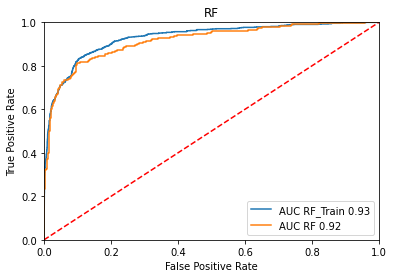

RF CLASSIFICATION ACCURACY
RF_Train  =  0.865981543624161
RF  =  0.8540268456375839
------


RF RMSE ACCURACY
RF_Train  =  1015.9166695104263
RF  =  2203.4958487415456
------




In [76]:
# Loan Default
WHO = "RF"

CLM = RandomForestClassifier(random_state=4, max_depth=5)
CLM = CLM.fit(X_train, Y_train[TARGET_BF])

TRAIN_CLM = getProbAccuracyScores(WHO + "_Train", CLM, X_train, Y_train[ TARGET_BF])
TEST_CLM = getProbAccuracyScores(WHO, CLM, X_test, Y_test[TARGET_BF])

print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

feature_cols = list(X_df.columns.values)
vars_RF_flag = getEnsembleTreeVars(CLM, feature_cols)

# Loss Amount
AMT = RandomForestRegressor(n_estimators=100, random_state=4)
AMT = AMT.fit( X_train, Y_train[TARGET_LA])

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, X_train, Y_train[TARGET_LA])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, X_test, Y_test[TARGET_LA])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

feature_cols = list(X_df.columns.values)
vars_tree_amt = getEnsembleTreeVars(AMT, feature_cols) 

## for i in vars_RF_amt:
##   print(i)

RF_CLM = TEST_CLM.copy()
RF_AMT = TEST_AMT.copy()

### Gradient Boosting (non-REG)

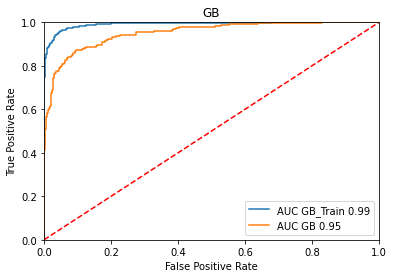

GB CLASSIFICATION ACCURACY
GB_Train  =  0.9658137583892618
GB  =  0.9177852348993288
------


GB RMSE ACCURACY
GB_Train  =  1500.9969536224444
GB  =  2350.023037847418
------




In [77]:
# Gradient Boosting
WHO = "GB"

CLM = GradientBoostingClassifier(random_state=4, max_depth=5)
CLM = CLM.fit( X_train, Y_train[TARGET_BF])

TRAIN_CLM = getProbAccuracyScores(WHO + "_Train", CLM, X_train, Y_train[TARGET_BF])
TEST_CLM = getProbAccuracyScores(WHO, CLM, X_test, Y_test[TARGET_BF])

print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

feature_cols = list(X_df.columns.values)
vars_GB_flag = getEnsembleTreeVars(CLM, feature_cols)

# Loss Amount
AMT = GradientBoostingRegressor(random_state=4, max_depth=5)
AMT = AMT.fit(X_train, Y_train[TARGET_LA])

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, X_train, Y_train[TARGET_LA])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, X_test, Y_test[TARGET_LA])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

feature_cols = list(X_df.columns.values )
vars_GB_amt = getEnsembleTreeVars(AMT, feature_cols)

##for i in vars_GB_amt :
##    print( i )

GB_CLM = TEST_CLM.copy()
GB_AMT = TEST_AMT.copy()

## Applying Regression to all variables ('REG_ALL')
 - Using `LogisticRegression()` and `LinearRegression()` on `TARGET_LA` 
 - Hyperparameters: `solver=newton-cg` outperformed `solver=liblinear`

Number of features used: 18 



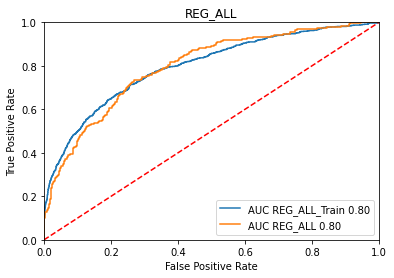

REG_ALL CLASSIFICATION ACCURACY
REG_ALL_Train  =  0.8385067114093959
REG_ALL  =  0.8330536912751678
------


REG_ALLRMSE ACCURACY
REG_ALL_Train  =  4298.846279206346
REG_ALL  =  4332.631738969421
------



LOAN DEFAULT
---------
Total Variables:  19
INTERCEPT  =  -2.3306549575502244
LOAN  =  -2.0781452280683852e-05
MORTDUE  =  -3.631470951741546e-06
VALUE  =  3.324882659813438e-06
YOJ  =  -0.00928674501193654
DEROG  =  0.5663190682013873
DELINQ  =  0.7479857858663778
CLAGE  =  -0.005373408778728647
NINQ  =  0.1751238288631761
CLNO  =  -0.014309422308958505
DEBTINC  =  0.05633909854948357
IMP_REASON_DebtCon  =  -0.22289863109429675
IMP_REASON_HomeImp  =  0.09176595820170938
IMP_JOB_Mgr  =  -0.08738277430632305
IMP_JOB_Office  =  -0.6488536336732066
IMP_JOB_Other  =  -0.07618788733316986
IMP_JOB_ProfExe  =  -0.11599250972356301
IMP_JOB_Sales  =  0.4711607512215555
IMP_JOB_Self  =  0.3261233809221234

LOSS AMOUNT
---------
Total Variables:  19
INTERCEPT  =  6603.264209086003
LOAN  =  0.14

In [78]:
# Apply regression to all variables 
WHO = "REG_ALL"

CLM = LogisticRegression(solver='newton-cg', random_state=4, max_iter=1000)
CLM = CLM.fit(X_train, Y_train[TARGET_BF])
print("Number of features used: {}".format(np.sum(CLM.coef_ !=0)),'\n')

TRAIN_CLM = getProbAccuracyScores(WHO + '_Train', CLM, X_train, Y_train[TARGET_BF])
TEST_CLM = getProbAccuracyScores(WHO, CLM, X_test, Y_test[TARGET_BF])

print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

# Loss Amount 
AMT = LinearRegression()
AMT = AMT.fit(X_train, Y_train[TARGET_LA])

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, X_train, Y_train[TARGET_LA])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, X_test, Y_test[TARGET_LA])
print_Accuracy(WHO + "RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

varNames = list(X_train.columns.values)

REG_ALL_CLM_COEF = getCoefLogit(CLM, X_train)
REG_ALL_AMT_COEF = getCoefLinear(AMT, X_train)

REG_ALL_CLM = TEST_CLM.copy()
REG_ALL_AMT = TEST_AMT.copy()

Notes:
* `'REG_TREE'` is ~11% less accurate than the decision tree labeled `'TREE'` displayed above (77% versus 88%)

## Decision Tree ('REG_TREE')

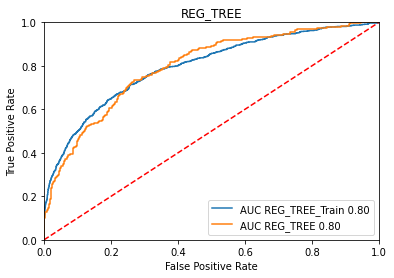

REG_TREE CLASSIFICATION ACCURACY
REG_TREE_Train  =  0.8385067114093959
REG_TREE  =  0.8330536912751678
------


REG_TREE RMSE ACCURACY
REG_TREE_Train  =  4298.846279206346
REG_TREE  =  4332.631738969421
------



LOAN DEFAULT
---------
Total Variables:  19
INTERCEPT  =  -2.3306549575502244
LOAN  =  -2.0781452280683852e-05
MORTDUE  =  -3.631470951741546e-06
VALUE  =  3.324882659813438e-06
YOJ  =  -0.00928674501193654
DEROG  =  0.5663190682013873
DELINQ  =  0.7479857858663778
CLAGE  =  -0.005373408778728647
NINQ  =  0.1751238288631761
CLNO  =  -0.014309422308958505
DEBTINC  =  0.05633909854948357
IMP_REASON_DebtCon  =  -0.22289863109429675
IMP_REASON_HomeImp  =  0.09176595820170938
IMP_JOB_Mgr  =  -0.08738277430632305
IMP_JOB_Office  =  -0.6488536336732066
IMP_JOB_Other  =  -0.07618788733316986
IMP_JOB_ProfExe  =  -0.11599250972356301
IMP_JOB_Sales  =  0.4711607512215555
IMP_JOB_Self  =  0.3261233809221234

LOSS AMOUNT
---------
Total Variables:  19
INTERCEPT  =  6603.264209086003
LOAN  

In [92]:
# Regression Decision Tree
WHO = "REG_TREE"

CLM = LogisticRegression(solver='newton-cg', max_iter=1000)
CLM = CLM.fit(X_train, Y_train[TARGET_BF])

TRAIN_CLM = getProbAccuracyScores(WHO + "_Train", CLM, X_train, Y_train[TARGET_BF])
TEST_CLM = getProbAccuracyScores(WHO, CLM, X_test, Y_test[TARGET_BF])

print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

# Loss Amount
AMT = LinearRegression()
AMT = AMT.fit(X_train, Y_train[TARGET_LA])

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, X_train, Y_train[TARGET_LA])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, X_test, Y_test[TARGET_LA])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

varNames = list(X_train.columns.values)

REG_TREE_CLM_COEF = getCoefLogit(CLM, X_train)
REG_TREE_AMT_COEF = getCoefLinear(AMT, X_train)

REG_TREE_CLM = TEST_CLM.copy()
REG_TREE_AMT = TEST_AMT.copy()

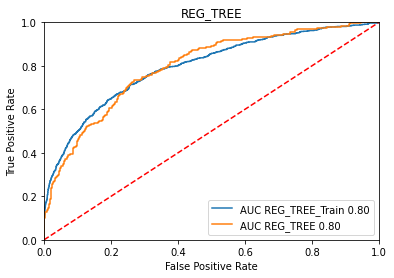

REG_TREECLASSIFICATION ACCURACY
REG_TREE_Train  =  0.8385067114093959
REG_TREE  =  0.8330536912751678
------


REG_TREERMSE ACCURACY
REG_TREE_Train  =  4298.846279206346
REG_TREE  =  4332.631738969421
------



LOAN DEFAULT
---------
Total Variables:  19
INTERCEPT  =  -2.3306549575502244
LOAN  =  -2.0781452280683852e-05
MORTDUE  =  -3.631470951741546e-06
VALUE  =  3.324882659813438e-06
YOJ  =  -0.00928674501193654
DEROG  =  0.5663190682013873
DELINQ  =  0.7479857858663778
CLAGE  =  -0.005373408778728647
NINQ  =  0.1751238288631761
CLNO  =  -0.014309422308958505
DEBTINC  =  0.05633909854948357
IMP_REASON_DebtCon  =  -0.22289863109429675
IMP_REASON_HomeImp  =  0.09176595820170938
IMP_JOB_Mgr  =  -0.08738277430632305
IMP_JOB_Office  =  -0.6488536336732066
IMP_JOB_Other  =  -0.07618788733316986
IMP_JOB_ProfExe  =  -0.11599250972356301
IMP_JOB_Sales  =  0.4711607512215555
IMP_JOB_Self  =  0.3261233809221234

LOSS AMOUNT
---------
Total Variables:  19
INTERCEPT  =  6603.264209086003
LOAN  = 

In [93]:
# Decision Tree using regression
WHO = "REG_TREE"

CLM = LogisticRegression(solver='newton-cg', max_iter=1000)
CLM = CLM.fit(X_train, Y_train[TARGET_BF])

TRAIN_CLM = getProbAccuracyScores(WHO + "_Train", CLM, X_train, Y_train[TARGET_BF])
TEST_CLM = getProbAccuracyScores(WHO, CLM, X_test, Y_test[TARGET_BF])

print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM]) 
print_Accuracy(WHO + "CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

# Loss Amount
AMT = LinearRegression()
AMT = AMT.fit(X_train, Y_train[TARGET_LA])

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, X_train, Y_train[TARGET_LA])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, X_test, Y_test[TARGET_LA])
print_Accuracy(WHO + "RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

varNames = list(X_train.columns.values)

REG_TREE_CLM_COEF = getCoefLogit(CLM, X_train)
REG_TREE_AMT_COEF = getCoefLinear(AMT, X_train)

REG_TREE_CLM = TEST_CLM.copy()
REG_TREE_AMT = TEST_AMT.copy()

## Random Forest ('REG_RF')
* Appears `'REG_RF' `accomplished the same test accuracy of 77% as `'REG_TREE'` using less variables

In [94]:
'''getEnsembleTreeVars() works best for decision trees, but not for linear regression and deep learning'''
def getEnsembleTreeVars(ENSTREE, varNames):
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) :
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList



('DEBTINC', 100)
('DELINQ', 65)
('DEROG', 43)
('CLAGE', 22)
('LOAN', 19)


('LOAN', 100)
('DELINQ', 74)
('CLNO', 26)
('DEBTINC', 25)




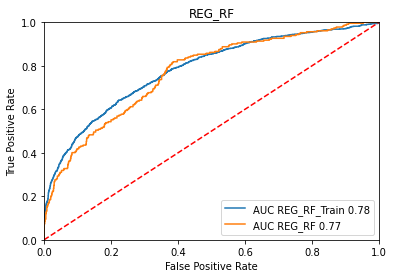

REG_RF CLASSIFICATION ACCURACY
REG_RF_Train  =  0.8345218120805369
REG_RF  =  0.8280201342281879
------


REG_RF RMSE ACCURACY
REG_RF_Train  =  4372.097268781967
REG_RF  =  4381.170241716728
------



LOAN DEFAULT
---------
Total Variables:  6
INTERCEPT  =  -2.4881656583510634
DEBTINC  =  0.05523728068320004
DELINQ  =  0.7016798416384644
DEROG  =  0.6023007628597047
CLAGE  =  -0.006254284282515459
LOAN  =  -1.9638547209014833e-05

LOSS AMOUNT
---------
Total Variables:  5
INTERCEPT  =  5551.478085406285
LOAN  =  0.15120496257955018
DELINQ  =  980.4588049888897
CLNO  =  66.94524698550617
DEBTINC  =  36.51133291298322


In [99]:
# Random Forest
WHO = "REG_RF"

# Variable selection for TARGET_BF
print('\n')
RF_flag = []
for i in vars_RF_flag:
    print(i)
    theVar = i[0]
    RF_flag.append(theVar)

# Variable selection for TARGET_LA
print('\n')
RF_amt = []
for i in vars_RF_amt:
    print(i)
    theVar = i[0]
    RF_amt.append(theVar)
print('\n')

CLM = LogisticRegression(solver='newton-cg', max_iter=1000)
CLM = CLM.fit(X_train[RF_flag], Y_train[TARGET_BF])

TRAIN_CLM= getProbAccuracyScores(WHO + "_Train", CLM, X_train[RF_flag], Y_train[TARGET_BF])
TEST_CLM= getProbAccuracyScores(WHO, CLM, X_test[RF_flag], Y_test[TARGET_BF])

print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

# Loss Amount
AMT = LinearRegression()
AMT = AMT.fit(X_train[RF_amt], Y_train[TARGET_LA])

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, X_train[RF_amt], Y_train[TARGET_LA])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, X_test[RF_amt], Y_test[TARGET_LA])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])


REG_RF_CLM_COEF = getCoefLogit(CLM, X_train[RF_flag])
REG_RF_AMT_COEF = getCoefLinear(AMT, X_train[RF_amt])

REG_RF_CLM = TEST_CLM.copy()
REG_RF_AMT = TEST_AMT.copy()

## Regression Gradient Boosting ('REG_GB')
* Results show a ~1% decrease in test data accuracy compared to `'REG_RF'` and `'REG_TREE'`
* Train % accuracy is ~3% less than the `'REG_RF'` and `'REG_TREE'`



('DEBTINC', 100)
('DELINQ', 33)
('CLAGE', 19)
('MORTDUE', 13)


('LOAN', 100)
('DEBTINC', 64)
('DELINQ', 63)
('CLNO', 30)
('MORTDUE', 28)
('CLAGE', 22)




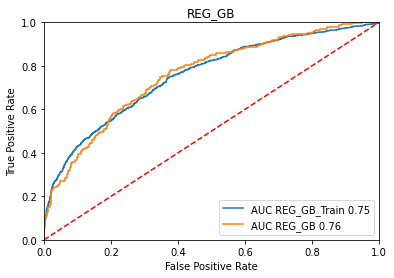

REG_GB CLASSIFICATION ACCURACY
REG_GB_Train  =  0.8263422818791947
REG_GB  =  0.8322147651006712
------


REG_GB RMSE ACCURACY
REG_GB_Train  =  4336.764218321065
REG_GB  =  4384.026587839649
------



LOAN DEFAULT
---------
Total Variables:  5
INTERCEPT  =  -2.3706869723722765
DEBTINC  =  0.053206727749661197
DELINQ  =  0.7717947311867781
CLAGE  =  -0.006758355139865484
MORTDUE  =  -2.1072098528776147e-06

LOSS AMOUNT
---------
Total Variables:  7
INTERCEPT  =  6494.998643005271
LOAN  =  0.15113851339973017
DEBTINC  =  28.16322825062782
DELINQ  =  982.0735214560528
CLNO  =  72.46685227867106
MORTDUE  =  0.005320922452217047
CLAGE  =  -6.471531406930691


In [96]:
# Regression Gradient Boosting
WHO = "REG_GB"

# Variable selection for TARGET_BF
print('\n')
GB_flag = []
for i in vars_GB_flag:
    print(i)
    theVar = i[0]
    GB_flag.append(theVar)

# Variable selection for TARGET_LA
print('\n')
GB_amt = []
for i in vars_GB_amt:
    print(i)
    theVar = i[0]
    GB_amt.append(theVar)
print('\n')

CLM = LogisticRegression(solver='newton-cg', max_iter=1000)
CLM = CLM.fit(X_train[GB_flag], Y_train[ TARGET_BF])

TRAIN_CLM = getProbAccuracyScores(WHO + "_Train", CLM, X_train[GB_flag], Y_train[TARGET_BF])
TEST_CLM = getProbAccuracyScores(WHO, CLM, X_test[GB_flag], Y_test[TARGET_BF])

print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

# Loan Default
AMT = LinearRegression()
AMT = AMT.fit(X_train[GB_amt], Y_train[TARGET_LA])

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, X_train[GB_amt], Y_train[TARGET_LA])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, X_test[GB_amt], Y_test[TARGET_LA])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

REG_GB_CLM_COEF = getCoefLogit(CLM, X_train[GB_flag])
REG_GB_AMT_COEF = getCoefLinear(AMT, X_train[GB_amt])

REG_GB_CLM = TEST_CLM.copy()
REG_GB_AMT = TEST_AMT.copy()

## Regression Stepwise by Features vs Performance 

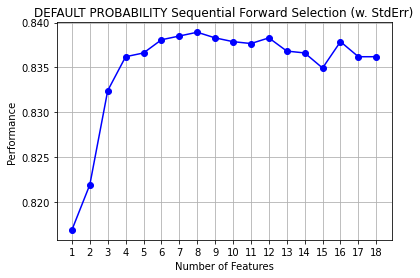

 ................... 
argmax
feature_names    (2, 3, 4, 5, 6, 9, 13, 17)
avg_score                          0.838925
Name: 8, dtype: object
 ................... 
('2', '3', '4', '5', '6', '9', '13', '17')
VALUE
YOJ
DEROG
DELINQ
CLAGE
DEBTINC
IMP_JOB_Office
IMP_JOB_Self


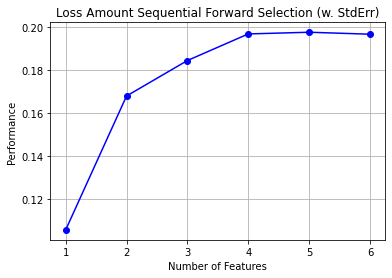

 ................... 
argmax
feature_names    (0, 2, 3, 4, 5)
avg_score               0.197538
Name: 5, dtype: object
 ................... 
('0', '2', '3', '4', '5')
LOAN
DELINQ
CLNO
MORTDUE
CLAGE
1000000 loops, best of 5: 1.02 µs per loop
peak memory: 232.35 MiB, increment: 0.11 MiB


In [98]:
U_train = X_train
stepVarNames = list(U_train.columns.values)
maxCols = U_train.shape[1]

sfs = SFS(LogisticRegression(solver='newton-cg', max_iter=1000),
           k_features=(1, maxCols),
           forward=True,
           floating=False,
           cv=3
           )
sfs.fit(U_train.values, Y_train[ TARGET_BF].values)

theFigure = plot_sfs(sfs.get_metric_dict(), kind=None)
plt.title('DEFAULT PROBABILITY Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
dfm = dfm[['feature_names', 'avg_score']]
dfm.avg_score = dfm.avg_score.astype(float)

print(" ................... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print( dfm.iloc[maxIndex, ] )
print(" ................... ")

stepVars = dfm.iloc[maxIndex, ]
stepVars = stepVars.feature_names
print(stepVars)

finalStepVars = []
for i in stepVars:
    index = int(i)
    try:
        theName = stepVarNames[index]
        finalStepVars.append(theName)
    except:
        pass

for i in finalStepVars:
    print(i)

U_train = X_train[finalStepVars]
U_test = X_test[finalStepVars]

V_train = X_train[GB_amt]
stepVarNames = list(V_train.columns.values)
maxCols = V_train.shape[1]

sfs = SFS( LinearRegression(),
           k_features=(1, maxCols),
           forward=True,
           floating=False,
           scoring = 'r2',
           cv=5
           )
sfs.fit(V_train.values, Y_train[TARGET_LA].values)

theFigure = plot_sfs(sfs.get_metric_dict(), kind=None )
plt.title('Loss Amount Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

dfm = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
dfm = dfm[['feature_names', 'avg_score']]
dfm.avg_score = dfm.avg_score.astype(float)

print(" ................... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print(dfm.iloc[maxIndex, ] )
print(" ................... ")

stepVars = dfm.iloc[maxIndex, ]
stepVars = stepVars.feature_names
print(stepVars)

finalStepVars = []
for i in stepVars:
    index = int(i)
    try:
        theName = stepVarNames[index]
        finalStepVars.append(theName)
    except:
        pass

for i in finalStepVars:
    print(i)

V_train = X_train[finalStepVars]
V_test = X_test[finalStepVars]

%timeit sum(range(100))
%memit

## Regression Stepwise ('REG_STEPWISE')

Notes:
* Consolidated ROC Curve Chart shows the most accurate model is our initial simple Decision Tree without regression with 88% test data accuracy

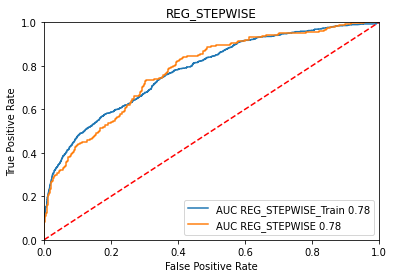

REG_STEPWISE CLASSIFICATION ACCURACY
REG_STEPWISE_Train  =  0.8382969798657718
REG_STEPWISE  =  0.8364093959731543
------


REG_STEPWISE RMSE ACCURACY
REG_STEPWISE_Train  =  4341.666202588129
REG_STEPWISE  =  4400.387413497322
------



LOAN DEFAULT
---------
Total Variables:  9
INTERCEPT  =  -2.595756104156473
VALUE  =  -4.3614045701084197e-07
YOJ  =  -0.011958174597432711
DEROG  =  0.5783892094574244
DELINQ  =  0.7250405287585759
CLAGE  =  -0.006260052487958779
DEBTINC  =  0.0545278486145018
IMP_JOB_Office  =  -0.6182512977708288
IMP_JOB_Self  =  0.359150041304967

LOSS AMOUNT
---------
Total Variables:  6
INTERCEPT  =  7368.098458711922
LOAN  =  0.15220509521610978
DELINQ  =  983.968282615192
CLNO  =  75.56473837927842
MORTDUE  =  0.005760128663155228
CLAGE  =  -6.698553798653446


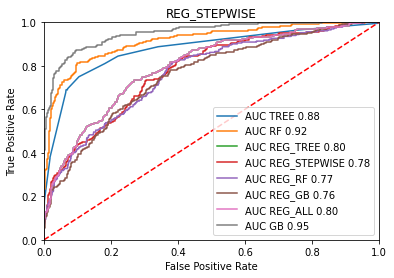

REG_STEPWISEALL CLASSIFICATION ACCURACY
GB  =  0.9177852348993288
TREE  =  0.886744966442953
RF  =  0.8540268456375839
REG_STEPWISE  =  0.8364093959731543
REG_TREE  =  0.8330536912751678
REG_ALL  =  0.8330536912751678
REG_GB  =  0.8322147651006712
REG_RF  =  0.8280201342281879
------


ALL Loss Amount MODEL ACCURACY
RF  =  2203.4958487415456
GB  =  2350.023037847418
TREE  =  3522.0650799548084
REG_ALL  =  4332.631738969421
REG_TREE  =  4332.631738969421
REG_RF  =  4381.170241716728
REG_GB  =  4384.026587839649
REG_STEPWISE  =  4400.387413497322
------




In [109]:
WHO = "REG_STEPWISE"

CLM = LogisticRegression(solver='newton-cg', max_iter=1000)
CLM = CLM.fit(U_train, Y_train[TARGET_BF])

TRAIN_CLM = getProbAccuracyScores(WHO + "_Train", CLM, U_train, Y_train[TARGET_BF])
TEST_CLM = getProbAccuracyScores(WHO, CLM, U_test, Y_test[TARGET_BF])

print_ROC_Curve(WHO, [TRAIN_CLM, TEST_CLM]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_CLM, TEST_CLM])

# Loss Amount
AMT = LinearRegression()
AMT = AMT.fit(V_train, Y_train[TARGET_LA])

TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, V_train,
                                 Y_train[TARGET_LA])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, V_test, Y_test[TARGET_LA])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

REG_STEP_CLM_COEF = getCoefLogit(CLM, U_train)
REG_STEP_AMT_COEF = getCoefLinear(AMT, V_train)

REG_STEP_CLM = TEST_CLM.copy()
REG_STEP_AMT = TEST_AMT.copy()

ALL_CLM = [TREE_CLM, RF_CLM, GB_CLM,
                      REG_ALL_CLM, REG_TREE_CLM, REG_RF_CLM,
                      REG_GB_CLM, REG_STEP_CLM]

ALL_CLM = sorted(ALL_CLM, reverse=True)
print_ROC_Curve(WHO, ALL_CLM)

ALL_CLM = sorted(ALL_CLM, key = lambda x: x[1], reverse=True)
print_Accuracy(WHO + "ALL CLASSIFICATION ACCURACY", ALL_CLM)


ALL_AMT = [TREE_AMT, RF_AMT, GB_AMT, REG_ALL_AMT, REG_TREE_AMT,
           REG_RF_AMT, REG_GB_AMT, REG_STEP_AMT]

ALL_AMT = sorted(ALL_AMT, key = lambda x: x[1])
print_Accuracy("ALL Loss Amount MODEL ACCURACY", ALL_AMT)